In [1]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

Text(0, 0.5, 'Values')

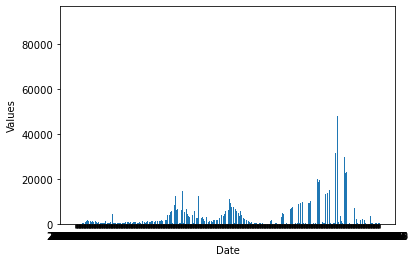

In [3]:
covid_df  = pd.read_csv('michigan_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

plt.bar(covid_df['Date'], covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
plt.xlabel('Date')
plt.ylabel('Values')

<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT', ylabel='Count'>

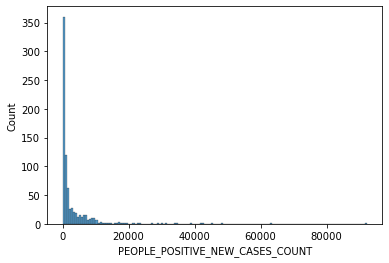

In [4]:
import seaborn as sns
sns.histplot(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

Distribution is not normal, could be an opportunity for Linear Models.

In [5]:
covid_df  = covid_df.set_index('Date')
covid_df.index = pd.to_datetime(covid_df.index)
covid_df = covid_df.sort_index()

In [6]:
from statsmodels.tsa.stattools import adfuller
adfuller(covid_df)

(-3.480173394765139,
 0.00851112451318688,
 21,
 768,
 {'1%': -3.4388933482333464,
  '5%': -2.8653106782623574,
  '10%': -2.5687778874376086},
 14970.437551017543)

Stationarity is Good. 

In [7]:
train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

## Cross val

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

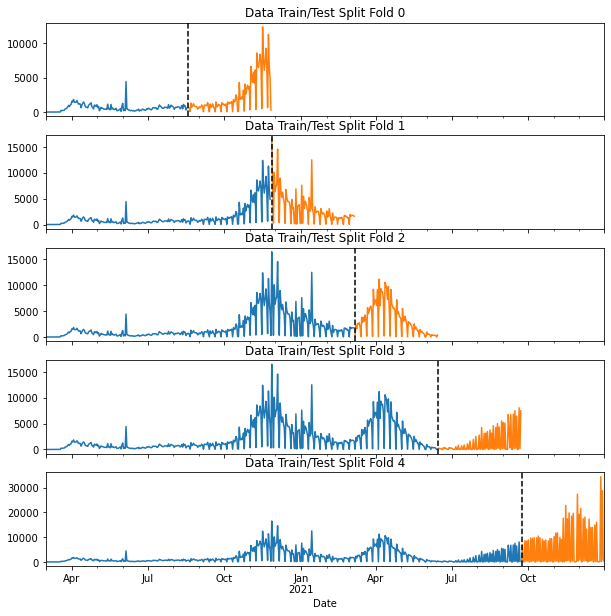

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_train):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## ACF & PACF

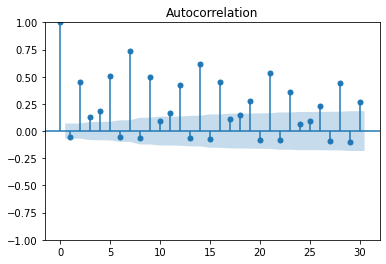

In [10]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

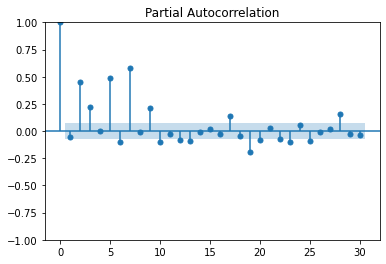

In [11]:
plot_pacf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

## Baseline ARIMA

In [12]:
from statsmodels.tsa.arima.model import ARIMA
base_cali_arima = ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(1, 0, 1))
base_cali_arima_fit = base_cali_arima.fit()

In [13]:
base_cali_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  671
Model:                              ARIMA(1, 0, 1)   Log Likelihood               -6446.590
Date:                             Tue, 05 Mar 2024   AIC                          12901.180
Time:                                     01:08:26   BIC                          12919.215
Sample:                                 03-01-2020   HQIC                         12908.165
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2542.5821   2871.685      0.885      0.376   -3085.818    8170.982
ar.L1          0.9923      0.008    130.970      0.000       0.977       1.007
ma.L1         -0.9117      0.014    -64.637      0.000      -0.939      -0.884
sigma2      1.293e+07      7.792   1.66e+06      0.000    1.29e+07    1.29e+07
===================================================================================
Ljung-Box (L1) (Q):                 129.99   Jarque-Bera (JB):              5202.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             129.76   Skew:                             2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+21. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

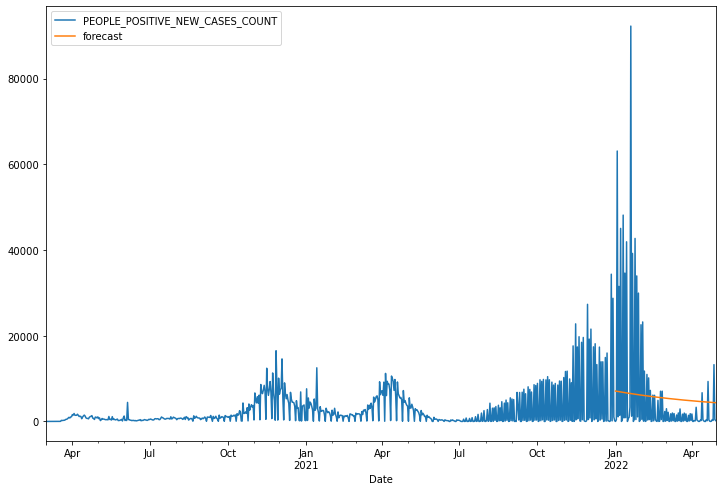

In [14]:
covid_df['forecast']= base_cali_arima_fit.forecast(steps = len(covid_test))
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

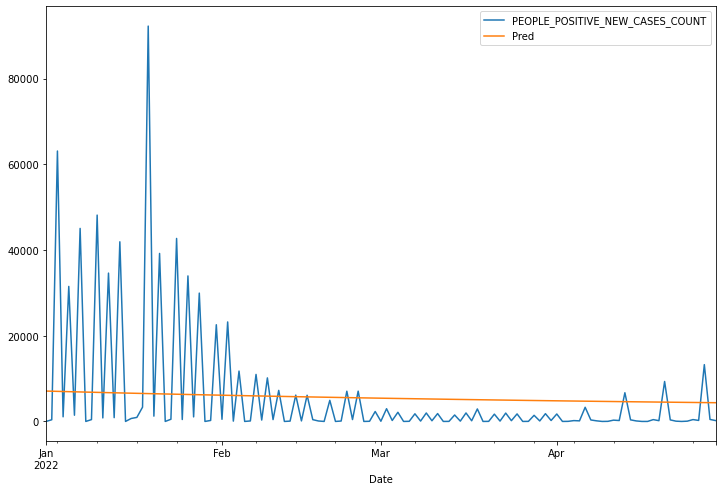

In [15]:
graph_df = pd.DataFrame(covid_test)
graph_df['Pred'] = base_cali_arima_fit.forecast(steps = len(covid_test))
graph_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Pred']].plot(figsize=(12,8))

In [16]:
print('MAE = ', mean_absolute_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('MASE = ', mase(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred'])))

MAE =  7998.93013972025
MASE =  0.7021396972413447
RMSE =  13916.4257081308


## Tuned ARIMA

Going to try to do a Box Cox transformation to be used on linear models.

In [17]:
from scipy.stats import boxcox

covid_train_boxcox = pd.DataFrame(covid_train)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].clip(lower=1)
to_transform = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
transformed_data, lambda_value = boxcox(to_transform)
print("Lambda value:", lambda_value)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'] = transformed_data

Lambda value: 0.17797926572716455


<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT_new', ylabel='Count'>

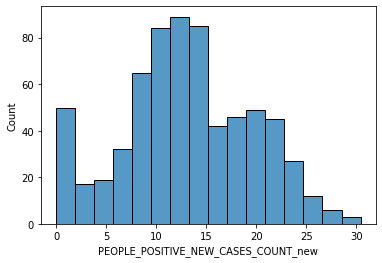

In [18]:
sns.histplot(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

New distribution here is much more normal than before, hopefully helps with improving the linear models. 

<BarContainer object of 671 artists>

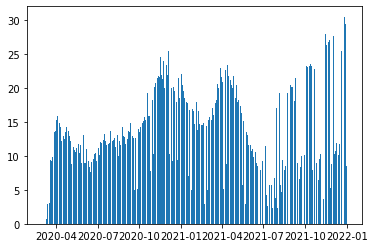

In [19]:
plt.bar(covid_train_boxcox.index, covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

In [20]:
# Grid Search

results=[]
for p in range(1,5):
    for q in range(1,5):
 #       cali_arima_gmodel=ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        cali_arima_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q)).fit()
        results.append([p,q,cali_arima_gmodel.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')


,p,q,aic
15,4,4,3862.877006
14,4,3,3904.039368
6,2,3,3979.152078
13,4,2,4059.379800
7,2,4,4065.764289
11,3,4,4108.290970
10,3,3,4119.669899
9,3,2,4139.411331
3,1,4,4141.683170
1,1,2,4147.513985


In [21]:
cali_after_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(4,1,4))
cali_after_gmodel_fit =cali_after_gmodel.fit()

<AxesSubplot:xlabel='Date'>

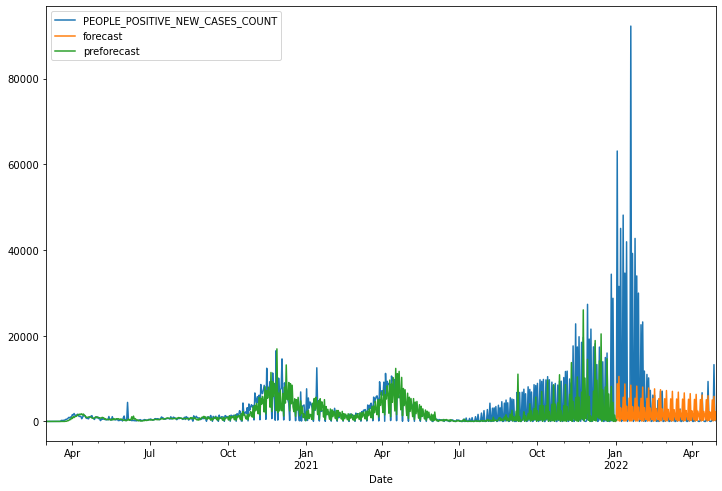

In [22]:
covid_df_predictions = pd.DataFrame(covid_df)

covid_df_predictions['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = covid_df_predictions['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['forecast'] = arima_back_transformed_one

covid_df_predictions['preforecast']= cali_after_gmodel_fit.predict(start = 0, end = 672)
arima_back_transform_two = covid_df_predictions['preforecast'].values
arima_back_transformed_two = np.power((arima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['preforecast'] = arima_back_transformed_two

covid_df_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

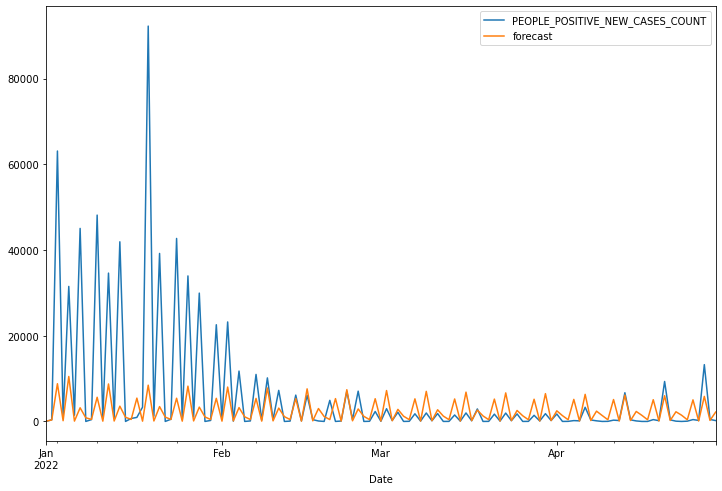

In [23]:
graph_df_1 = pd.DataFrame(covid_test)
graph_df_1['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_1['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_1['forecast'] = arima_back_transformed_one
graph_df_1.dropna(inplace=True)
graph_df_1[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [24]:
print('MAE = ', mean_absolute_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('MASE = ', mase(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast'])))

MAE =  5315.34884159478
MASE =  0.46657707483116256
RMSE =  13377.356535797735


## Baseline SARIMA

In [25]:
import statsmodels.api as sm
baseline_sarima= sm.tsa.statespace.SARIMAX(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima = baseline_sarima.fit()

<AxesSubplot:xlabel='Date'>

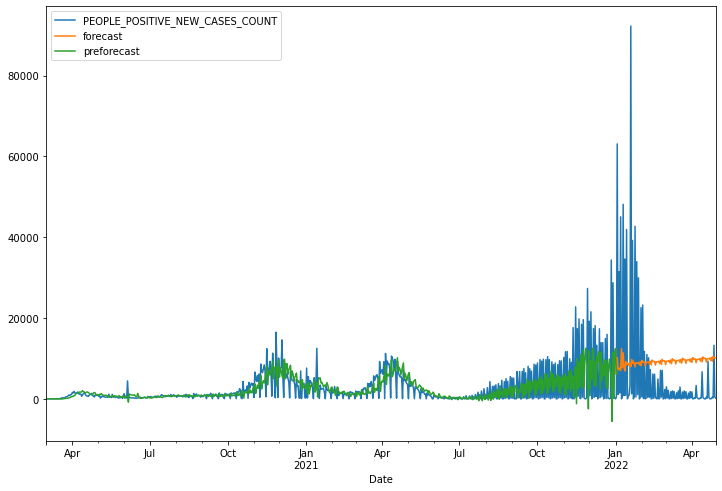

In [26]:
covid_df['forecast']= results_sarima.forecast(steps = len(covid_train))
covid_df['preforecast'] = results_sarima.predict(start = 0, end = 672)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

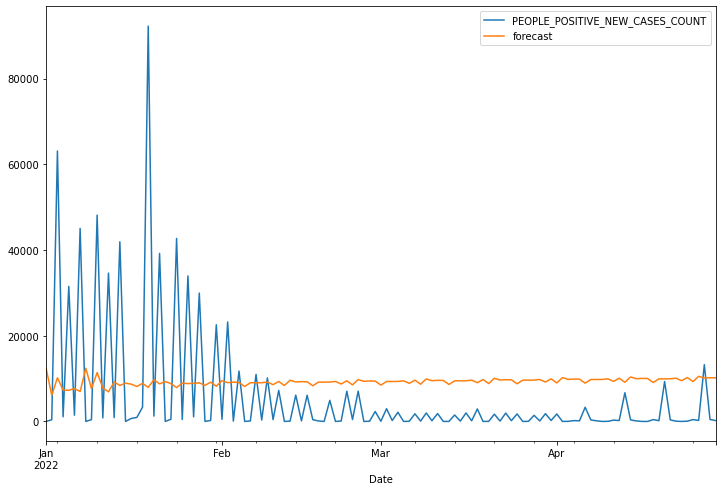

In [27]:
graph_df_3 = pd.DataFrame(covid_test)
graph_df_3['forecast']= results_sarima.forecast(steps = len(covid_test))
graph_df_3[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [28]:
print('MAE = ', mean_absolute_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('MASE = ', mase(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast'])))

MAE =  10842.97611944013
MASE =  0.9517877812050862
RMSE =  14850.285375297583


## Tuned SARIMA

In [29]:

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    # Beaware of the data input, use your training set
                    model=sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])


1 1 1 1
1 1 1 2
1 1 2 1
1 1 2 2
1 2 1 1
1 2 1 2
1 2 2 1
1 2 2 2
2 1 1 1
2 1 1 2
2 1 2 1
2 1 2 2
2 2 1 1
2 2 1 2
2 2 2 1
2 2 2 2


In [30]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
14,2,2,2,1,4098.354681
15,2,2,2,2,4117.553014
13,2,2,1,2,4124.633174
12,2,2,1,1,4134.687315
10,2,1,2,1,4161.724065
2,1,1,2,1,4166.626339
3,1,1,2,2,4167.867773
11,2,1,2,2,4169.849120
1,1,1,1,2,4173.486423
9,2,1,1,2,4174.111181


In [40]:
sarima = sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(2, 1, 2),seasonal_order=(2,1,1,12))
results = sarima.fit()

<AxesSubplot:xlabel='Date'>

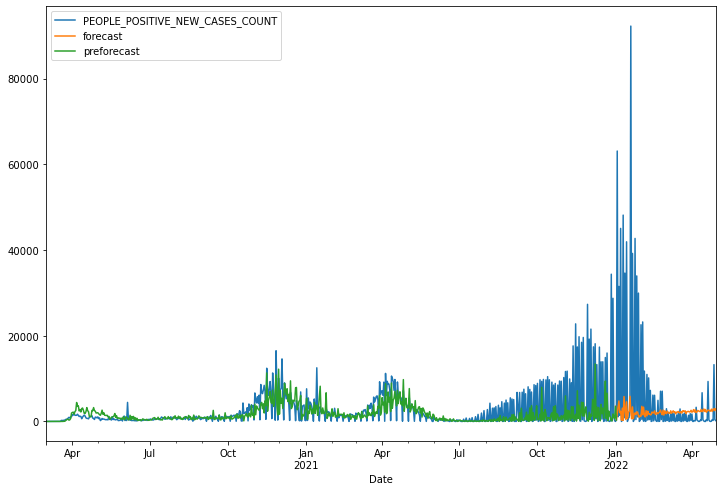

In [41]:
covid_df_sarima_predictions = pd.DataFrame(covid_df)

covid_df_sarima_predictions['forecast']=results.forecast(steps = len(covid_test))
sarima_back_transform_one = covid_df_sarima_predictions['forecast'].values
sarima_back_transformed_one = np.power((sarima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['forecast'] = sarima_back_transformed_one

covid_df_sarima_predictions['preforecast'] = results.predict(start = 0, end = 672)
sarima_back_transform_two = covid_df_sarima_predictions['preforecast'].values
sarima_back_transformed_two = np.power((sarima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['preforecast'] = sarima_back_transformed_two

covid_df_sarima_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

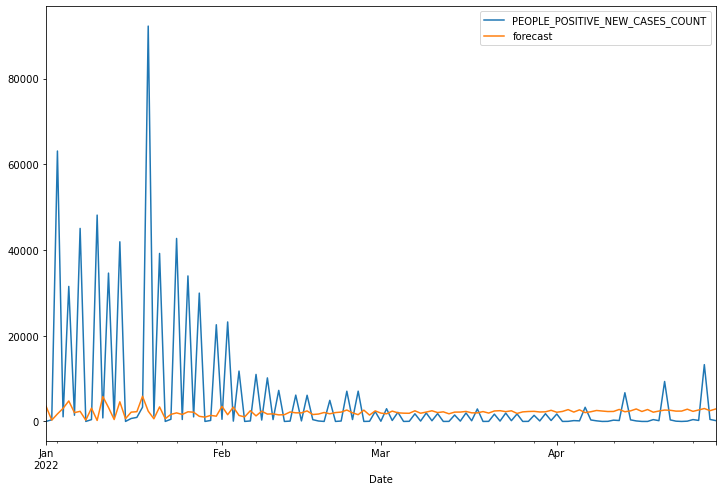

In [42]:
graph_df_4 = pd.DataFrame(covid_test)
graph_df_4['forecast']= results.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_4['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_4['forecast'] = arima_back_transformed_one
graph_df_4[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [43]:
print('MAE = ', mean_absolute_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('MASE = ', mase(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast'])))

MAE =  6363.019022285198
MASE =  0.5585407262982421
RMSE =  14684.579279327474


## Auto-ARIMA

In [35]:
from pmdarima import auto_arima

In [36]:
auto_model = auto_arima(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4149.097, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4773.203, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4450.908, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4240.936, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4771.204, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4149.000, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4195.509, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4200.451, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4153.298, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4174.103, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4201.974, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3980.456, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4120.942, Time=0.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4067.112, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

3979.152078252111


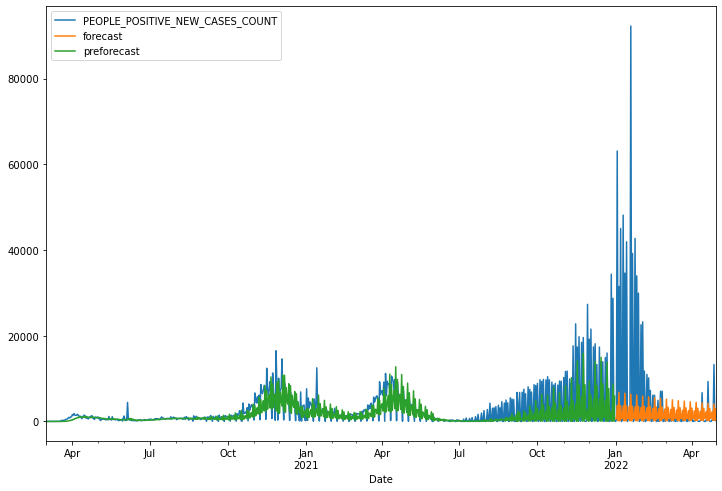

In [37]:
covid_auto_predictions = pd.DataFrame(covid_df)

auto_predictions = auto_model.predict(n_periods=len(covid_test))
auto_predictions = np.power((auto_predictions * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['forecast'] = auto_predictions

auto_predict_before = auto_model.fittedvalues()
auto_predict_before = np.power((auto_predict_before * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['preforecast'] = auto_predict_before

covid_auto_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))
print(auto_model.aic())

<AxesSubplot:xlabel='Date'>

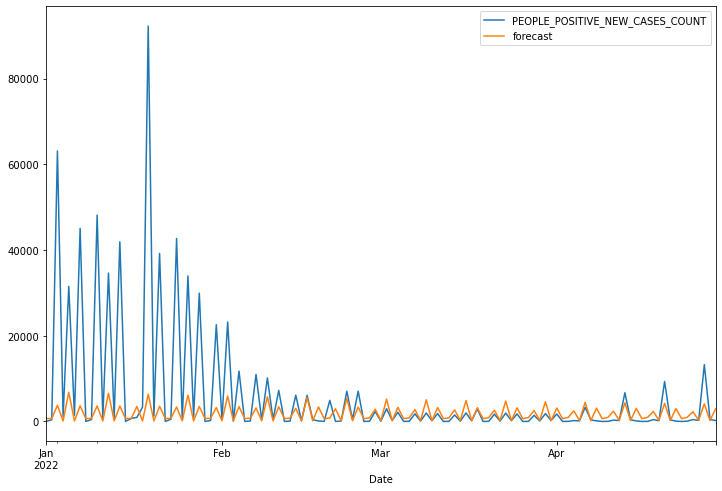

In [38]:
graph_df_5 = pd.DataFrame(covid_test)
graph_df_5['forecast']= auto_model.predict(n_periods=len(covid_test))
arima_back_transform_one = graph_df_5['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_5['forecast'] = arima_back_transformed_one
graph_df_5.dropna(inplace=True)
graph_df_5[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [39]:
print('MAE = ', mean_absolute_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('MASE = ', mase(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast'])))

MAE =  5296.607500963235
MASE =  0.4649319749231649
RMSE =  13873.312059963759
